# [Darshan-LDMS Integrator](https://ovis-hpc.readthedocs.io/en/latest/ldms/ldms-streams.html#darshans)

### A **framework** that integrates Darshan + LDMS to provide low-latency monitoring of I/O events during runtime. 

CARTOON HERE

- **[Darshan](https://www.mcs.anl.gov/research/projects/darshan/)**: a lightweight I/O characterization tool that captures I/O access information in HPC applications storing information in memory during execution. When the job ends, it merges I/O data from all processes and generates a profile and/or trace (DXT) file.

- **[Lightweight Distributed Metric Service (LDMS)](https://ovis-hpc.readthedocs.io/en/latest/ldms/ldms-quickstart.html)**: a low-overhead production monitoring system for HPC machines. Capability to collect, transport, aggregate and store timeseries data during runtime.

![Darshan-LDMS Integration](newdarshanconnector.jpg)

### Main benefits

- Captures information at runtime: without filesystem overhead or on node memory cost
- Captures absolute time-series data with high precision: can be used to correlate with other system utilization logs
- Captures read/write/**close/open/flushes**
- Captures POSIX, MPI-IO and stdio: distinguishes between **STDIN/STDOUT/STDERR** 
- Stores all application processes in JSON or CSV format: easier to be processed by most data analysis tools

### Installation

- Documentation: https://ovis-hpc.readthedocs.io/en/latest/ldms/ldms-streams.html#darshan
- Available in Darshan's main branch: https://github.com/darshan-hpc/darshan/blob/main/darshan-runtime/lib/darshan-ldms.c

### Installation in the cloud AWS

- Notebook Tutorial [here](./aws_configuring.ipynb)
- Video tutorial - one node [here](https://drive.google.com/file/d/1xFmOxJpRhOOWyEAMkv6fxEGIFoTA4_YZ/view?usp=sharing)
- Video tutorial - multinode [here](https://drive.google.com/file/d/1kucLEIjtf3sB74HQ26iXd71TRH37eAOQ/view?usp=sharing)

### Example of CSV file collected:

In [1]:
!head -n5 ./../ior/eclipse/darshan-ldms-output/csv/16m-4m/19040551-IOR_pscratch_32_none.csv

uid,exe,job_id,rank,ProducerName,file,record_id,module,type,max_byte,switches,flushes,cnt,op,pt_sel,irreg_hslab,reg_hslab,ndims,npoints,off,len,start,dur,total,timestamp
12345,/projects/ovis/darshanConnector/apps/rhel9.7/ior/build/bin/ior,19040551,0,n21,<STDIN>,9.22337E+18,STDIO,MET,-1,-1,-1,1,open,-1,-1,-1,-1,-1,-1,-1,0,0,0,1713473238.945981
12345,/projects/ovis/darshanConnector/apps/rhel9.7/ior/build/bin/ior,19040551,0,n21,<STDOUT>,9.22337E+18,STDIO,MET,-1,-1,-1,1,open,-1,-1,-1,-1,-1,-1,-1,0,0,0,1713473238.945981
12345,/projects/ovis/darshanConnector/apps/rhel9.7/ior/build/bin/ior,19040551,0,n21,<STDERR>,7.23826E+18,STDIO,MET,-1,-1,-1,1,open,-1,-1,-1,-1,-1,-1,-1,0,0,0,1713473238.945981
12345,N/A,19040551,0,n21,N/A,9.22337E+18,STDIO,MOD,51,-1,0,1,write,-1,-1,-1,-1,-1,0,52,0.044958,0.000003,0.000003,1713473238.990943


It captures 25 columns with information about the job, I/O and timestamp.

##  Darshan-LDMS Integrator Analyzer [Demonstration]

We present a set of metrics and functions to process the Darshan-LDMS Integrator output file an generate informative feedback for the user in the format of a report and visualizations. Having absolute timestamps of individual I/O events can also be used to perform I/O analysis and identify bottlenecks at a deeper level, correlating with other system usage data, which will be explored.

#### Input

LDMS-Darshan Integration CSV file for an [IOR benchmark](https://github.com/hpc/ior) execution using 36 ranks, for 2 tasks (iterations) using blocks size of 16MB, and transfer size of 4MB, for 32 segments:

*/ior -i 2 -b 16m -t 4m -s 32 -F -C -e -k -o /pscratch/user/iorTest/darshan*

#### Output

- Progress Rate Summary - *txt* file 
- Visualizations - *png* images

#### Metrics - I/O Progress Rate 

**[Average](https://www.researchgate.net/publication/301700628_Using_SimGrid_to_Evaluate_the_Impact_of_AMPI_Load_Balancing_In_a_Geophysics_HPC_Application?channel=doi&linkId=5723a6f208ae262228aa71a4&showFulltext=true)**: Measures the average time spent computing I/O operations per rank.

$$
\text{AVG} = \frac{\text{Cumulative I/O duration}}{\text{Number of ranks}}
$$

**[Imbalance time](https://link.springer.com/chapter/10.1007/978-3-540-74466-5_17)**: Measures the execution time that would be gained if all ranks execute I/O operations for the same amount of time - perfectly balanced.

$$
\text{IT} = \text{Max. cumulative I/O duration} - \text{AVG}
$$

**[Percent Imbalance](https://dl.acm.org/doi/10.1145/2304576.2304601)**: Measures the performance in % that could be gained with this balanced distribution.

$$
\text{PI} = \left( \frac{\text{Max. cumulative I/O duration}}{\text{AVG}} - 1 \right) \times 100
$$

**[Imbalance Percentage](https://link.springer.com/chapter/10.1007/978-3-540-74466-5_17)**: Measures how bad is the imbalance in a range of 0 to 100, where 0 is perfectly balanced. If the IP is lower than the PI it suggests that the load imbalance is more influenced by the number of ranks than by the difference between the maximum and average loads.

$$
\text{IP} = \left( \frac{\text{Max. cumulative I/O duration} - \text{AVG}}{\text{Max. cumulative I/O duration}} \right) \times \left( \frac{\text{Number of ranks}}{\text{Number of ranks} - 1} \right)
$$

### Define **input** filename and **output** filepath

In [2]:
FILEPATH="./../ior/eclipse/darshan-ldms-output/csv/16m-4m/"
INPUTFILE="./../ior/eclipse/darshan-ldms-output/csv/16m-4m/19047177-IOR_pscratch_32_none.csv"

### Code to generate the report

In [101]:
import os, csv, time, glob, argparse, psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
from math import sqrt, ceil
import rpy2.robjects as ro
import seaborn as sns
from datetime import datetime
import warnings 
warnings.filterwarnings('ignore') 


class Job:

    def __init__(self, job, ranks, nodes, users, filename, exe):
        
        self.job = job
        self.ranks = ranks
        self.nodes = nodes
        self.users = users
        self.filename = filename
        self.exe = exe

def app_phase(df, output_file, self):
    write_to_file("---------------------------------------")
    write_to_file("EXECUTION SUMMARY PER APPLICATION PHASE:")
    write_to_file("---------------------------------------")

# Calculate and write general statistics in a file
def get_statistics(df, output_file, self):

    with open(output_file, 'w') as f:

        def write_to_file(*args):
            print(" ".join(map(str, args)), file=f, flush=True)

        write_to_file("---------------------------------------")
        write_to_file("JOB CHARACTERISTICS:")
        write_to_file("---------------------------------------")
        write_to_file("Job ID:", self.job)
        write_to_file(len(self.ranks), "Rank (s):", sorted(self.ranks))
        write_to_file(len(self.nodes), "Node (s):", sorted(self.nodes))
        write_to_file("User ID:", self.users)
        write_to_file("Directory:", self.exe)
        write_to_file("Modules collected:", df['module'].unique())
        write_to_file("Module events (MOD):", list(df.type).count('MOD'))
        write_to_file("Meta events (MET):", list(df.type).count('MET'))

        df_read = df[df['op'] == "read"]
        df_write = df[df['op'] == "write"]

        write_to_file("---------------------------------------")
        write_to_file("I/O OPERATIONS:")
        write_to_file("---------------------------------------")

        exec_time = round(df['end'].max() - df['start'].min(), 5)
        write_to_file("Total I/O makespan:", exec_time, "seconds")
        write_to_file("Cumulative I/O duration:", round(df['dur'].sum(), 5), "seconds")
        write_to_file("Bandwidth (MiB/second):", round((df['len'].sum() / exec_time) / (1024 ** 2), 5))
        write_to_file("IOPS:", round(len(df)/exec_time, 5), "\n")

        current_op = None
        phase_start = None
        total_durations = {'read': 0, 'write': 0, 'open': 0, 'close': 0}

        def update_total_duration(op, phase_start, phase_end, length):
            if current_op is not None and current_op == op:
                total_durations[op] += (phase_end - phase_start)

        for index, row in df.iterrows():
            if current_op is None or current_op != row['op']:
                update_total_duration(current_op, phase_start, row['end'], row['len'])
                current_op = row['op']
                phase_start = row['start']

        # Get the last phase
        update_total_duration(current_op, phase_start, row['end'], row['len'])

        pivot_df = df.pivot_table(index=None, columns='op', values='len', aggfunc='sum')
        for op, duration in total_durations.items():
            write_to_file(f'Duration {op}s: {round(duration, 4)} seconds')

        write_to_file("\nREADS - ", len(df_read))
        write_to_file("Cumulative I/O duration:",round(df_read['dur'].sum(),2))
        write_to_file("Total data size:",round(df_read['len'].sum() / (1024 ** 2)),  "MiB")
        write_to_file("Min data size per rank:", round(df_read.groupby('rank')['len'].agg('sum').min() / (1024 ** 2)), "MiB")
        write_to_file("Max data size per rank:", round(df_read.groupby('rank')['len'].agg('sum').max() / (1024 ** 2)), "MiB")
        # write_to_file("Bandwidth (MiB/second):", round((df_read['len'].sum() / total_durations['read']) / (1024 ** 2), 2))
        # write_to_file("IOPS:", round(len(df_read)/total_durations['read'], 2))

        write_to_file("\nWRITES - ", len(df_write))
        write_to_file("Cumulative I/O duration:",round(df_write['dur'].sum(), 2))
        write_to_file("Total data size:",round(df_write['len'].sum() / (1024 ** 2)),  "MiB")
        write_to_file("Min data size per rank:", round(df_write.groupby('rank')['len'].agg('sum').min() / (1024 ** 2)), "MiB")
        write_to_file("Max data size per rank:", round(df_write.groupby('rank')['len'].agg('sum').max() / (1024 ** 2)), "MiB")
        # write_to_file("Bandwidth (MiB/second):", round((df_write['len'].sum() / total_durations['write']) / (1024 ** 2),2))
        # write_to_file("Mean IOPS:", round((df_write.groupby('rank').size() / df_write.groupby('rank')['dur'].sum()).mean(), 2))
        # write_to_file("IOPS:", round(len(df_write)/total_durations['write'], 2))

        # IMBALANCE METRICS:
        write_to_file("---------------------------------------")
        write_to_file("I/O PROGRESS RATE:")
        write_to_file("---------------------------------------")
        # Get difference between execution time and time processing I/O per rank
        
        df_idle = df.groupby('rank')['dur'].sum().reset_index()
        df_idle.columns = ['Rank ID', 'Rank I/O Time']
        df_idle['Total Bytes'] = df.groupby('rank')['len'].agg('sum')
        df_idle['Rank I/O Time'] = round(df_idle['Rank I/O Time'], 2)
        df_idle['Total I/O Time - Rank I/O Time'] = round(exec_time - df_idle['Rank I/O Time'], 2)
        df_idle = df_idle.sort_values(by='Rank I/O Time', ascending=False)
        
        num_ranks = len(self.ranks)
        average = df['dur'].sum() / num_ranks
        write_to_file("- Average:", round(average, 2), "seconds")
        std = np.std(df_idle['Rank I/O Time'])
        write_to_file("- Standard deviation", round(std, 2), "seconds")
        it = df_idle['Rank I/O Time'].max() - average
        write_to_file("- Imbalance Time:", round(it, 2), "seconds")
        pi = ((df_idle['Rank I/O Time'].max() / average) - 1) * 100
        write_to_file("- Percent Imbalance:", round(pi, 2), "%")
        ip = (it / df_idle['Rank I/O Time'].max()) * (num_ranks / (num_ranks - 1))
        write_to_file("- Imbalance Percentage:", round(ip, 2), "%")

        write_to_file("---------------------------------------")
        write_to_file("SUMMARY PER RANK: \n(ordered by higher I/O time - all ops)")
        write_to_file("---------------------------------------")
        df.loc[:, 'start'] = pd.to_datetime(df['start'], unit='s').dt.round('S')
        df.loc[:, 'end'] = pd.to_datetime(df['end'], unit='s').dt.round('S')
        # write_to_file(df_idle)
        write_to_file(df_idle.to_string(index=False))

### Run to get jobs report

In [102]:
# Read CSV file, define jobs characteristics and calculate load metrics
def main(filename, filepath): 

    df = pd.read_csv(filename, engine="pyarrow")

    # Get basic info about each Job:
    local_df = pd.DataFrame()
    for i in df.job_id.unique():
        
        local_df = df[df['job_id'] == i].copy()
        job = Job(i, local_df['rank'].unique(), local_df['ProducerName'].unique(),local_df['uid'].unique(), 
            local_df['file'].unique(), local_df['exe'].unique())

        local_df.loc[:, 'start'] = local_df['timestamp'] - local_df['dur']
        local_df.loc[:, 'end'] = local_df['timestamp']
        
        # Job characteristics and statistics:  
        output_file = filename.replace(".csv", ".txt")
        get_statistics(local_df, output_file, job)

if __name__ == '__main__':

    start_time_exec = time.time()
    main(INPUTFILE, FILEPATH)   
    end_time_exec = time.time()
    print("Execution time:", end_time_exec - start_time_exec, "seconds")

Execution time: 0.8350682258605957 seconds


### Checking output file:

In [103]:
!cat $FILEPATH/19047177-IOR_pscratch_32_none.txt

---------------------------------------
JOB CHARACTERISTICS:
---------------------------------------
Job ID: 19047177
36 Rank (s): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
1 Node (s): ['n1119']
User ID: [12345]
Directory: ['/projects/ovis/darshanConnector/apps/rhel9.7/ior/build/bin/ior' 'N/A']
Modules collected: ['STDIO' 'POSIX']
Module events (MOD): 18713
Meta events (MET): 147
---------------------------------------
I/O OPERATIONS:
---------------------------------------
Total I/O makespan: 9.29758 seconds
Cumulative I/O duration: 200.57687 seconds
Bandwidth (MiB/second): 7929.8056
IOPS: 2028.48483 

Duration reads: 1.1035 seconds
Duration writes: 7.2238 seconds
Duration opens: 0.9484 seconds
Duration closes: 1.5842 seconds

READS -  9216
Cumulative I/O duration: 29.94
Total data size: 36864 MiB
Min data size per rank: 1024 MiB
Max data size per rank: 1024 MiB

WRITES -  9353
Cumulative I/O 

### Code for generating visualizations

In [66]:
# Show total I/O duration per rank and operation
def plot_time_per_operation(df, filepath, job_id):

    colors = {'write': 'blue', 'open': 'green', 'close': 'red', 'read': 'orange'} 
    
    fig, axes = plt.subplots(1, 4, figsize=(8, 3.5)) 

    for ax, operation in zip(axes, ['write','read', 'open', 'close']):
        df_subset = df[df['op'] == operation].groupby('rank')['dur'].sum().reset_index()
        df_subset.plot(kind='barh', y='dur', x='rank', color=colors[operation], ax=ax, width=0.8)
        ax.set_xlabel('Total I/O duration (sec)')
        ax.set_ylabel('Rank')
        ax.set_yticks(range(0, df_subset['rank'].max(), ceil(df_subset['rank'].max()/10)))
        ax.set_title(operation.capitalize()) 
        ax.get_legend().remove()
        ax.set_xlim(0, df_subset['dur'].max())

    plt.tight_layout()
    plt.show()
    plt.close()
    plt.clf()
    return
 
# Show bandwidth per rank and operation 
def plot_bandwidth_per_rank(df, filepath, job_id):

    df = df[df['op'].isin(['write', 'read'])]
    df['bw'] = np.where(df['dur'] != 0, df['len'] / (df['dur'] * 2**20), 0)
    colors = {'write': 'blue', 'read': 'orange'}
    fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))
     
    for ax, operation in zip(axes, ['write','read']):
        df_subset = df[df['op'] == operation].groupby('rank')['bw'].mean().reset_index()
        df_subset.plot(kind='barh', y='bw', x='rank', color=colors[operation], ax=ax, width=0.8)

        ax.set_xlabel('Total Bandwidth (MiB/second)')
        ax.set_ylabel('Rank')
        ax.set_yticks(range(0, df_subset['rank'].max(), ceil(df_subset['rank'].max()/10)))
        ax.set_title(operation.capitalize()) 
        ax.get_legend().remove()

    plt.tight_layout()
    plt.show()
    plt.clf()
    plt.close()

    return

# Plot each I/O event per rank during time
def plot_temporal(df, filepath, job_id):

    df['start'] = pd.to_datetime(df['timestamp'], unit='s') - pd.to_timedelta(df['dur'], unit='s')
    df[['start', 'timestamp']] = df[['start', 'timestamp']].apply(pd.to_datetime)
    df['dur'] = pd.to_timedelta(df['dur'], unit='s')

    colors = {'write': 'blue', 'open': 'green', 'close': 'red', 'read': 'orange'} 
    df['color'] = df['op'].map(colors)
    fig, ax = plt.subplots(figsize=(18, 3.5))

    ax.barh(y=df['rank'], width=df['dur'], left=df['start'], color=df['color'])
    ax.set_xlabel('Time of the day')
    ax.set_ylabel('Rank')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S.%f'[:-3]))
    ax.set_yticks(range(0, df['rank'].max(), ceil(df['rank'].max()/10)))
    legend_labels = [plt.Line2D([0], [0], color=color, linewidth=3, linestyle='-') for op, color in colors.items()]
    ax.legend(legend_labels, colors.keys(), loc='upper right')
    first_date = df['start'].iloc[0]
    ax.set_title(first_date.strftime("Date: " + '%Y-%m-%d'))
    ax.set_ylim(df['rank'].min()-0.5, df['rank'].max()+0.5)
    min_time = df['start'].min()
    max_time = df['start'].max()

    plt.show()
    plt.clf()
    plt.close()

    return


def plot_temporal_points(df, filepath, job_id):

    df['start'] = pd.to_datetime(df['timestamp'], unit='s') - pd.to_timedelta(df['dur'], unit='s')
    df[['start', 'timestamp']] = df[['start', 'timestamp']].apply(pd.to_datetime)
    df['dur'] = pd.to_timedelta(df['dur'], unit='s')

    colors = {'write': 'blue', 'open': 'green', 'close': 'red', 'read': 'orange'} 
    df['color'] = df['op'].map(colors)
    fig, ax = plt.subplots(figsize=(18, 5))

    # Plot bars for reads and writes
    for op in ['read', 'write']:
        op_data = df[df['op'] == op]
        ax.barh(y=op_data['rank'], width=op_data['dur'], left=op_data['start'], color=op_data['color'])

    # Plot points for opens and closes 
    op_data = df[df['op'] == 'open']
    ax.scatter(op_data['start'], op_data['rank'], color=op_data['color'], label=op, zorder=5, marker="2")
    op_data = df[df['op'] == 'close']
    ax.scatter(op_data['start'], op_data['rank'], color=op_data['color'], label=op, zorder=5, marker="1") 

    ax.set_xlabel('Time of the day')
    ax.set_ylabel('Rank')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S.%f'[:-3]))
    ax.set_yticks(range(0, df['rank'].max() + 1, ceil(df['rank'].max()/10)))

    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=op) for op, color in colors.items() if op in ['read', 'write']]
    legend_elements += [plt.Line2D([0], [0], marker='2', color=colors['open'], markersize=10, markerfacecolor=colors['open'], label='open')]
    legend_elements += [plt.Line2D([0], [0], marker='1', color=colors['close'], markersize=10, markerfacecolor=colors['close'], label='close')]
    
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0.)

    ax.set_ylim(df['rank'].min()-0.5, df['rank'].max()+0.5)
    first_date = df['start'].iloc[0]
    ax.set_title(first_date.strftime("Date: %Y-%m-%d"))

    plt.show()
    plt.clf()
    plt.close()

    return

### Run to get visualizations

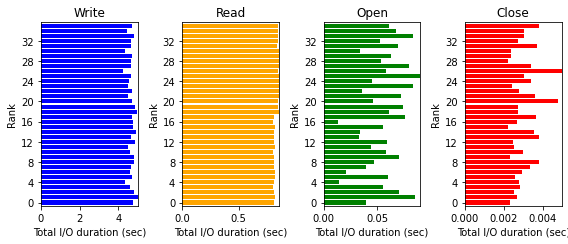

<Figure size 432x288 with 0 Axes>

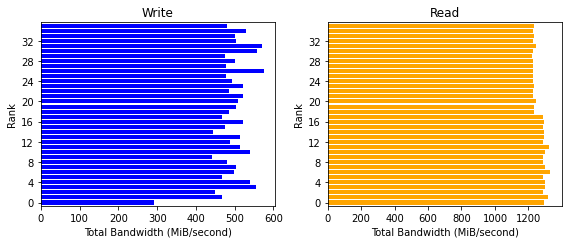

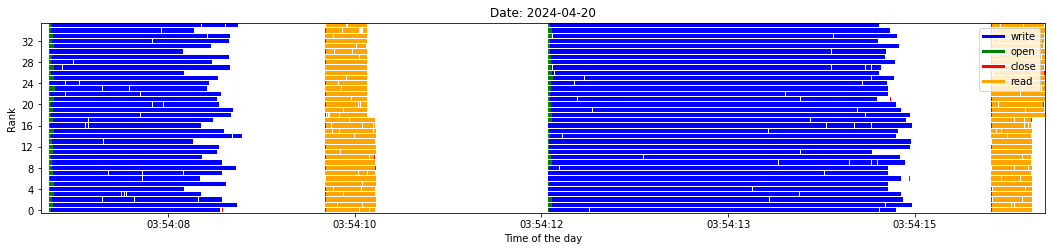

Execution time: 17.923619747161865 seconds


In [104]:
import warnings 
warnings.filterwarnings('ignore') 

# Read file and generate visualizations
def main(filename, filepath): 

    df = pd.read_csv(filename, engine="pyarrow")

    # Get basic info about each Job:
    local_df = pd.DataFrame()
    for i in df.job_id.unique():
        
        local_df = df[df['job_id'] == i].copy()
        plot_time_per_operation(local_df, filepath, i)
        plot_bandwidth_per_rank(local_df, filepath, i)
        plot_temporal(local_df, filepath, i)
        
if __name__ == '__main__':

    start_time_exec = time.time()
    main(INPUTFILE, FILEPATH)   
    end_time_exec = time.time()
    print("Execution time:", end_time_exec - start_time_exec, "seconds")

### Run to get occurrences of opens/closes

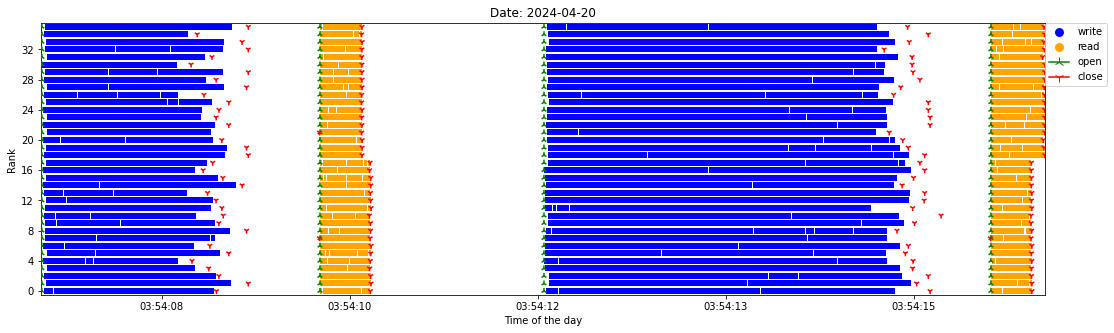

Execution time: 16.654547691345215 seconds


In [106]:
# Read file and generate visualizations
def main(filename, filepath): 

    df = pd.read_csv(filename, engine="pyarrow")

    # Get basic info about each Job:
    local_df = pd.DataFrame()
    for i in df.job_id.unique():
        
        local_df = df[df['job_id'] == i].copy()
        plot_temporal_points(local_df, filepath, i)
        
if __name__ == '__main__':

    start_time_exec = time.time()
    main(INPUTFILE, FILEPATH)   
    end_time_exec = time.time()
    print("Execution time:", end_time_exec - start_time_exec, "seconds")